In [82]:
import pandas as pd
import seaborn as sns

In [83]:
train_data = pd.read_csv('train.csv')

### EDA

In [84]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [85]:
train_data.shape

(8693, 14)

In [86]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [87]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [88]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [89]:
train_data.isna().sum().sort_values(ascending=False) / train_data.shape[0] * 100

CryoSleep       2.496261
ShoppingMall    2.392730
VIP             2.335212
HomePlanet      2.312205
Name            2.300702
Cabin           2.289198
VRDeck          2.162660
FoodCourt       2.105142
Spa             2.105142
Destination     2.093639
RoomService     2.082135
Age             2.059128
PassengerId     0.000000
Transported     0.000000
dtype: float64

### Pre-processing

In [90]:
def preprocess(data):
    data[["Deck", "Num", "Side"]] = data.Cabin.str.split('/', expand=True)
    data["Deck"] = data.Deck.fillna(data["Deck"].mode().values[0])
    data.loc[data.Side.isna(), "Side"] = data[data.Side.isna()].apply(lambda x: data[data.Deck == x.Deck].Side.mode().values[0], axis=1)
    data['CabinLocation'] = data['Deck'].astype(str) + '_' + data['Side']

    data["Age"] = data["Age"].fillna(data.Age.mean())
    data["Age"] = data.Age.astype(int)
    
    data["RoomService"] = data["RoomService"].fillna(0)
    data["FoodCourt"] = data["FoodCourt"].fillna(0)
    data["ShoppingMall"] = data["ShoppingMall"].fillna(0)
    data["Spa"] = data["Spa"].fillna(0)
    data["VRDeck"] = data["VRDeck"].fillna(0)
    
    data["TotalSpending"] = data["RoomService"] + data["FoodCourt"] + data["ShoppingMall"] + data["Spa"] + data["VRDeck"]
    
    data["CryoSleep"] = data.CryoSleep.fillna(data.CryoSleep.mode().values[0])
    data["CryoSleep"] = data.CryoSleep.astype(int)
    
    data["VIP"] = data.VIP.fillna(data.VIP.mode().values[0])
    data["VIP"] = data.VIP.astype(int)
    
    data["HomePlanet"] = data.HomePlanet.fillna(data.HomePlanet.mode().values[0])
    data["Destination"] = data.Destination.fillna(data.Destination.mode().values[0])
    
    data['FamilyID'] = data['PassengerId'].str.split('_').str[0]

    # Group by 'FamilyID' and count the number of members
    data['FamilyGroupSize'] = data.groupby('FamilyID')['PassengerId'].transform('count')
    
    data.drop(columns=["Name", "Cabin", "Num", "PassengerId", "FamilyID"], axis=1, inplace=True)
    
    return data


In [91]:
train_data = preprocess(train_data)

In [92]:
train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,CabinLocation,TotalSpending,FamilyGroupSize
0,Europa,0,TRAPPIST-1e,39,0,0.0,0.0,0.0,0.0,0.0,False,B,P,B_P,0.0,1
1,Earth,0,TRAPPIST-1e,24,0,109.0,9.0,25.0,549.0,44.0,True,F,S,F_S,736.0,1
2,Europa,0,TRAPPIST-1e,58,1,43.0,3576.0,0.0,6715.0,49.0,False,A,S,A_S,10383.0,2
3,Europa,0,TRAPPIST-1e,33,0,0.0,1283.0,371.0,3329.0,193.0,False,A,S,A_S,5176.0,2
4,Earth,0,TRAPPIST-1e,16,0,303.0,70.0,151.0,565.0,2.0,True,F,S,F_S,1091.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,0,55 Cancri e,41,1,0.0,6819.0,0.0,1643.0,74.0,False,A,P,A_P,8536.0,1
8689,Earth,1,PSO J318.5-22,18,0,0.0,0.0,0.0,0.0,0.0,False,G,S,G_S,0.0,1
8690,Earth,0,TRAPPIST-1e,26,0,0.0,0.0,1872.0,1.0,0.0,True,G,S,G_S,1873.0,1
8691,Europa,0,55 Cancri e,32,0,0.0,1049.0,0.0,353.0,3235.0,False,E,S,E_S,4637.0,2


### Feature Engineering

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=["Transported"], axis=1), train_data["Transported"], random_state=42, test_size=0.3)

In [95]:
X_train = train_data.drop(columns=["Transported"], axis=1)

In [96]:
from sklearn.preprocessing import StandardScaler

In [97]:
scaler = StandardScaler()

In [98]:
# feature_data = scaler.fit_transform(X_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpending", "Age"]])
feature_data = scaler.fit_transform(X_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age", "TotalSpending"]])

In [99]:
feature_matrix = pd.DataFrame(feature_data, columns=scaler.get_feature_names_out())

In [100]:
# val_feature_data = scaler.transform(X_val[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "TotalSpending", "Age"]])
val_feature_data = scaler.transform(X_val[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age","TotalSpending"]])

In [101]:
val_feature_matrix = pd.DataFrame(val_feature_data, columns=scaler.get_feature_names_out())

In [102]:
feature_matrix = pd.concat([feature_matrix, X_train[["CryoSleep", "VIP", "HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"]].reset_index().drop(columns=["index"], axis=0)], axis=1)
# feature_matrix = pd.concat([feature_matrix, X_train[["CryoSleep", "VIP", "HomePlanet", "Destination", "Deck", "Side"]].reset_index().drop(columns=["index"], axis=0)], axis=1)

In [103]:
val_feature_matrix = pd.concat([val_feature_matrix, X_val[["CryoSleep", "VIP", "HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"]].reset_index().drop(columns=["index"], axis=0)], axis=1)
# val_feature_matrix = pd.concat([val_feature_matrix, X_val[["CryoSleep", "VIP", "HomePlanet", "Destination", "Deck", "Side"]].reset_index().drop(columns=["index"], axis=0)], axis=1)

In [104]:
X_train['CabinLocation'], fact_unique = X_train.CabinLocation.factorize()

In [105]:
X_val['CabinLocation'] = pd.Categorical(X_val["CabinLocation"], categories=fact_unique)

In [106]:
from sklearn.preprocessing import OneHotEncoder

In [107]:
ohc = OneHotEncoder(sparse=False, handle_unknown="ignore")

In [108]:
deck_side_features = ohc.fit_transform(feature_matrix[["HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"]])
# deck_side_features = ohc.fit_transform(feature_matrix[["HomePlanet", "Destination", "Deck", "Side"]])

/Users/utkarshdabholkar/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [109]:
deck_side_features_val = ohc.transform(val_feature_matrix[["HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"]])
# deck_side_features_val = ohc.transform(val_feature_matrix[["HomePlanet", "Destination", "Deck", "Side"]])

In [110]:
feature_matrix = pd.concat([feature_matrix, pd.DataFrame(deck_side_features, columns=ohc.get_feature_names_out())], axis=1)

In [111]:
feature_matrix.drop(columns=["HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"], axis=1, inplace=True)
# feature_matrix.drop(columns=["HomePlanet", "Destination", "Deck", "Side"], axis=1, inplace=True)

In [112]:
val_feature_matrix = pd.concat([val_feature_matrix, pd.DataFrame(deck_side_features_val, columns=ohc.get_feature_names_out())], axis=1)

In [113]:
val_feature_matrix.drop(columns=["HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"], axis=1, inplace=True)
# val_feature_matrix.drop(columns=["HomePlanet", "Destination", "Deck", "Side"], axis=1, inplace=True)

In [114]:
feature_matrix

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,TotalSpending,CryoSleep,VIP,HomePlanet_Earth,...,CabinLocation_T_P,CabinLocation_T_S,FamilyGroupSize_1,FamilyGroupSize_2,FamilyGroupSize_3,FamilyGroupSize_4,FamilyGroupSize_5,FamilyGroupSize_6,FamilyGroupSize_7,FamilyGroupSize_8
0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0.710602,-0.514066,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,-0.335517,-0.251479,0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.268001,1.959998,-0.283579,5.695623,-0.219796,2.035686,3.190333,0,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.333105,0.523010,0.336851,2.687176,-0.092818,0.292154,1.332604,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.125652,-0.237159,-0.031059,0.231374,-0.261240,-0.893447,-0.124824,0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,-0.333105,3.992336,-0.283579,1.189173,-0.197751,0.850085,2.531369,0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-0.753965,-0.514066,1,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8690,-0.333105,-0.281027,2.846999,-0.269737,-0.263003,-0.196035,0.154175,0,0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8691,-0.333105,0.376365,-0.283579,0.043013,2.589576,0.222413,1.140302,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Training

In [122]:
from sklearn.svm import SVC

In [123]:
svm_model = SVC(kernel="linear")

In [124]:
# svm_model.fit(feature_matrix, y_train)
svm_model.fit(feature_matrix, train_data["Transported"])

SVC(kernel='linear')

In [125]:
y_pred = svm_model.predict(val_feature_matrix)

In [126]:
from sklearn.metrics import classification_report, accuracy_score

In [127]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.74      0.78      1289
        True       0.77      0.85      0.81      1319

    accuracy                           0.79      2608
   macro avg       0.80      0.79      0.79      2608
weighted avg       0.80      0.79      0.79      2608



In [128]:
print(accuracy_score(y_val, y_pred))

0.7937116564417178


### Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier

In [130]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [131]:
# rf.fit(feature_matrix, y_train)
rf.fit(feature_matrix, train_data["Transported"])

RandomForestClassifier(random_state=42)

In [132]:
rf_y_pred = rf.predict(val_feature_matrix)

In [133]:
print(classification_report(y_val, rf_y_pred))

              precision    recall  f1-score   support

       False       0.98      0.95      0.96      1289
        True       0.95      0.98      0.96      1319

    accuracy                           0.96      2608
   macro avg       0.96      0.96      0.96      2608
weighted avg       0.96      0.96      0.96      2608



In [134]:
print(accuracy_score(y_val, rf_y_pred))

0.9635736196319018


<Axes: >

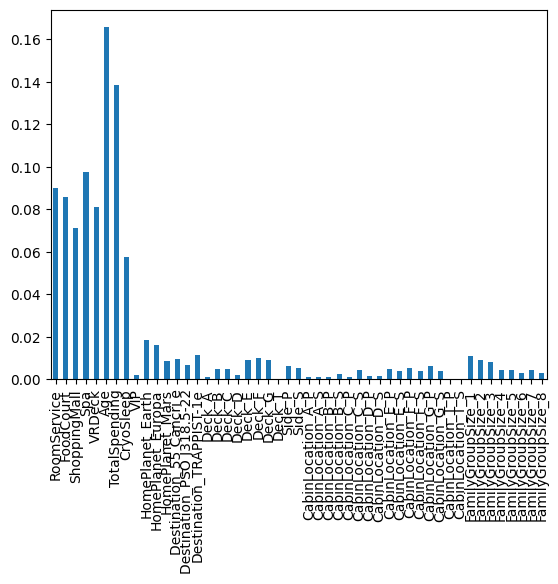

In [135]:
pd.Series(rf.feature_importances_, index=val_feature_matrix.columns).plot(kind="bar")

In [143]:
test_data = pd.read_csv("test.csv")

In [144]:
pid_df = test_data[["PassengerId"]]

In [145]:
test_data = preprocess(test_data)

In [146]:
test_data["CabinLocation"] = pd.Categorical(test_data.CabinLocation, categories=fact_unique)

In [147]:
test_feature_data = scaler.transform(test_data[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age", "TotalSpending"]])
test_feature_matrix = pd.DataFrame(test_feature_data, columns=scaler.get_feature_names_out())
# test_feature_matrix = pd.concat([test_feature_matrix, test_data[["CryoSleep", "VIP", "HomePlanet", "Destination", "Deck", "Side"]].reset_index().drop(columns=["index"], axis=0)], axis=1)
test_feature_matrix = pd.concat([test_feature_matrix, test_data[["CryoSleep", "VIP", "HomePlanet", "Destination", "Deck", "Side", "CabinLocation", "FamilyGroupSize"]].reset_index().drop(columns=["index"], axis=0)], axis=1)
# deck_side_features_test = ohc.transform(test_feature_matrix[["HomePlanet", "Destination", "Deck", "Side"]])
deck_side_features_test = ohc.transform(test_feature_matrix[["HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"]])
test_feature_matrix = pd.concat([test_feature_matrix, pd.DataFrame(deck_side_features_test, columns=ohc.get_feature_names_out())], axis=1)
test_feature_matrix.drop(columns=["HomePlanet", "Destination", "Deck", "Side", "CabinLocation","FamilyGroupSize"], axis=1, inplace=True)


In [53]:
rf_test_pred = rf.predict(test_feature_matrix)

In [54]:
output = pd.concat([pid_df, pd.DataFrame(rf_test_pred, columns=["Transported"])], axis=1)

In [55]:
output.to_csv("output_full_rf.csv", index=False)

In [56]:
svm_test_pred = svm_model.predict(test_feature_matrix)

In [57]:
output_svm = pd.concat([pid_df, pd.DataFrame(svm_test_pred, columns=["Transported"])], axis=1)

In [58]:
output_svm.to_csv("output_full_svm.csv", index=False)

In [148]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# Train the classifier
xgb_clf.fit(feature_matrix, train_data["Transported"])

# Predict the labels for the test set
yx_pred = xgb_clf.predict(val_feature_matrix)

# Calculate the accuracy
accuracy = accuracy_score(y_val, yx_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_val, yx_pred))


# You can also get the feature importances
importances = xgb_clf.feature_importances_
# Map feature importances to the corresponding column names
feature_importance_dict = dict(zip(feature_matrix.columns, importances))
print("Feature Importances:")
for feature, importance in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{feature}: {importance:.3f}")

Accuracy: 0.90
              precision    recall  f1-score   support

       False       0.93      0.88      0.90      1289
        True       0.88      0.93      0.91      1319

    accuracy                           0.90      2608
   macro avg       0.91      0.90      0.90      2608
weighted avg       0.91      0.90      0.90      2608

Feature Importances:
HomePlanet_Earth: 0.208
TotalSpending: 0.079
Deck_E: 0.066
HomePlanet_Europa: 0.056
CabinLocation_G_P: 0.031
FoodCourt: 0.030
CryoSleep: 0.028
CabinLocation_C_S: 0.025
ShoppingMall: 0.025
CabinLocation_B_P: 0.024
CabinLocation_B_S: 0.023
Spa: 0.023
VRDeck: 0.020
Deck_G: 0.017
Side_P: 0.015
RoomService: 0.015
Destination_TRAPPIST-1e: 0.015
CabinLocation_D_P: 0.015
Deck_F: 0.014
CabinLocation_E_S: 0.014
CabinLocation_D_S: 0.014
FamilyGroupSize_5: 0.014
Deck_A: 0.014
CabinLocation_F_P: 0.014
Deck_C: 0.012
VIP: 0.012
Destination_PSO J318.5-22: 0.012
Age: 0.012
HomePlanet_Mars: 0.012
CabinLocation_F_S: 0.011
FamilyGroupSize_4: 0.011
C

In [149]:
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [150]:
xgboost_pred = xgb_clf.predict(test_feature_matrix)

In [151]:
output = pd.concat([pid_df, pd.DataFrame(xgboost_pred, columns=["Transported"])], axis=1)

In [152]:
output['Transported'] = output['Transported'].astype(bool)

In [153]:
output.to_csv("output1_full_XG.csv", index=False)